In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import json

from PIL import Image
from google import genai

import tt

(640, 640)


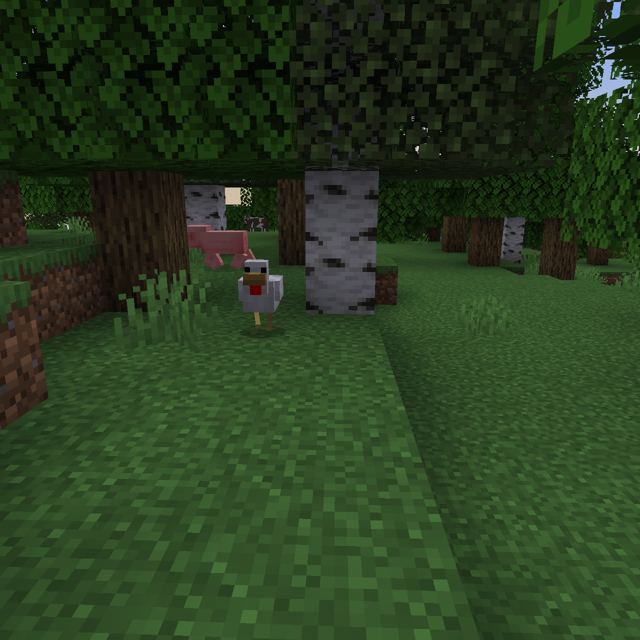

In [3]:
mobs_path = Path.home() / "src/data/mobs1/images"
image_fname = mobs_path / '06092b21-2024-10-20_22.22.09.png'
image = Image.open(image_fname)
image640 = image.resize((image.width // 2, image.height // 2))
print(image640.size)
display(image640)

In [4]:
CLASSES = [ 'chicken', 'cow', 'creeper', 'enderman', 'pig', 'player', 'sheep',
'skeleton', 'spider', 'villager', 'zombie' ]
CLASSES.sort()
CLASSES_MINECRAFT = [f"minecraft {x}" for x in CLASSES]

In [5]:
from google import genai
def gemini_detect(image, prompt):
    client = genai.Client()
    config = genai.types.GenerateContentConfig(response_mime_type="application/json")
    response = client.models.generate_content(model="gemini-2.5-flash", contents=[image, prompt], config=config)

    bounding_boxes = json.loads(response.text)
    return bounding_boxes

In [6]:
prompt_docs = f"""Detect {", ".join(CLASSES)}. The box_2d should be [ymin, xmin, ymax, xmax] normalized to 0-1000."""
prompt0 = f"""Task: Detect {", ".join(CLASSES)}. Return AT MOST 10 detections."""
prompt1 = f"""Task: Detect {", ".join(CLASSES)}. Return AT MOST 10 detections.

Output: Return ONLY a valid JSON array (no prose, no code fences). For each detection, emit an object with exactly these keys:
{{
  "box_2d": [ymin, xmin, ymax, xmax],
  "label": <class>
}}

Box format rules:
- Coordinates are NORMALIZED to the image on a 0-1000 scale.
  - (ymin, xmin) is the top-left corner of the box.
  - (ymax, xmax) is the bottom-right corner of the box.
  - y increases downward; x increases to the right.
- Numbers must be 0-1000 (floats allowed). If a box would extend outside the image, CLIP to this range.
- Do not include any extra fields.
- If nothing is found, return [].
"""

In [7]:
image_detect = image640.copy()

bbox_docs = gemini_detect(image_detect, prompt_docs)
print(bbox_docs)
bbox0 = gemini_detect(image_detect, prompt0)
print(bbox0)
bbox1 = gemini_detect(image_detect, prompt1)
print(bbox1)

# bboxes = tt.gemini_to_bboxes(gemini_bboxes)
# print(bboxes)

[{'box_2d': [386, 365, 517, 444], 'label': 'chicken'}, {'box_2d': [337, 287, 428, 395], 'label': 'pig'}, {'box_2d': [330, 375, 368, 417], 'label': 'cow'}]
[{'box_2d': [332, 375, 362, 417], 'label': 'cow'}, {'box_2d': [399, 368, 517, 444], 'label': 'chicken'}, {'box_2d': [351, 290, 421, 399], 'label': 'pig'}]
[{'box_2d': [288, 423, 349, 461], 'label': 'cow'}, {'box_2d': [395, 317, 512, 421], 'label': 'chicken'}, {'box_2d': [313, 295, 422, 379], 'label': 'pig'}]


In [11]:
display(tt.bbs_to_df(tt.gemini_to_bboxes(bbox_docs)))
display(tt.bbs_to_df(tt.gemini_to_bboxes(bbox0)))
display(tt.bbs_to_df(tt.gemini_to_bboxes(bbox1)))

,label,x1,y1,x2,y2
0,chicken,0.365,0.386,0.444,0.517
1,cow,0.375,0.330,0.417,0.368
2,pig,0.287,0.337,0.395,0.428


,label,x1,y1,x2,y2
0,chicken,0.368,0.399,0.444,0.517
1,cow,0.375,0.332,0.417,0.362
2,pig,0.290,0.351,0.399,0.421


,label,x1,y1,x2,y2
0,chicken,0.317,0.395,0.421,0.512
1,cow,0.423,0.288,0.461,0.349
2,pig,0.295,0.313,0.379,0.422


In [16]:
bbox_docs

[{'box_2d': [386, 365, 517, 444], 'label': 'chicken'},
 {'box_2d': [337, 287, 428, 395], 'label': 'pig'},
 {'box_2d': [330, 375, 368, 417], 'label': 'cow'}]

(640, 640)
chicken 233 247 284 330
pig 183 215 252 273
cow 240 211 266 235


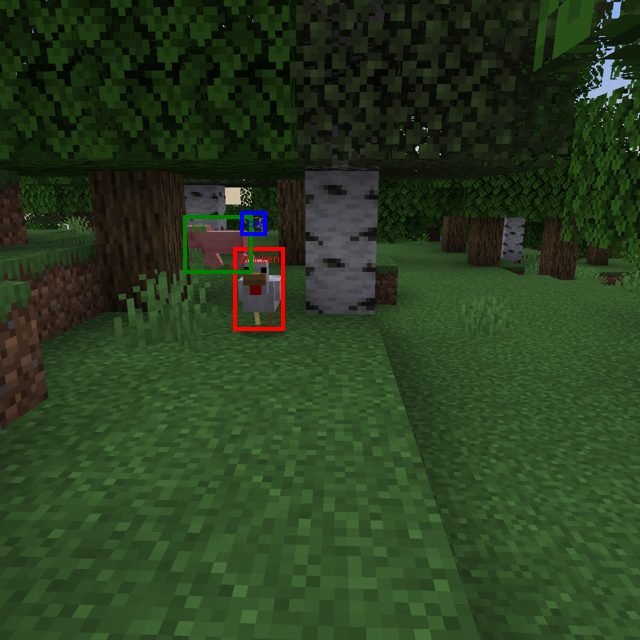

In [30]:
plot_bounding_boxes(image640, bbox_docs)

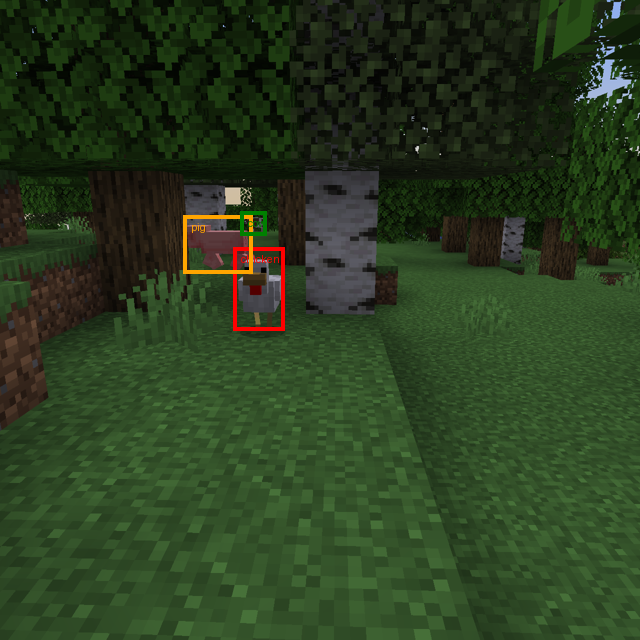

In [15]:
display(tt.plot_bb(image640, tt.gemini_to_bboxes(bbox_docs), CLASSES))

In [29]:
import json
import random
import io
from PIL import Image, ImageDraw, ImageFont
from PIL import ImageColor

additional_colors = [colorname for (colorname, colorcode) in ImageColor.colormap.items()]

def plot_bounding_boxes(im, bounding_boxes):
    """
    Plots bounding boxes on an image with markers for each a name, using PIL, normalized coordinates, and different colors.

    Args:
    img_path: The path to the image file.
    bounding_boxes: A list of bounding boxes containing the name of the object
    and their positions in normalized [y1 x1 y2 x2] format.
    """

    # Load the image
    img = im.copy()
    width, height = img.size
    print(img.size)
    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Define a list of colors
    colors = [ 'red', 'green', 'blue', 'yellow', 'orange', 'pink', 'purple',
    'brown', 'gray', 'beige', 'turquoise', 'cyan', 'magenta', 'lime', 'navy',
    'maroon', 'teal', 'olive', 'coral', 'lavender', 'violet', 'gold', 'silver',
    ] + additional_colors

    # Parsing out the markdown fencing
    # bounding_boxes = parse_json(bounding_boxes)

    # font = ImageFont.truetype("NotoSansCJK-Regular.ttc", size=14)
    font = None

    # Iterate over the bounding boxes
    # for i, bounding_box in enumerate(json.loads(bounding_boxes)):
    for i, bounding_box in enumerate(bounding_boxes):
        # Select a color from the list
        color = colors[i % len(colors)]

        # Convert normalized coordinates to absolute coordinates
        abs_y1 = int(bounding_box["box_2d"][0]/1000 * height)
        abs_x1 = int(bounding_box["box_2d"][1]/1000 * width)
        abs_y2 = int(bounding_box["box_2d"][2]/1000 * height)
        abs_x2 = int(bounding_box["box_2d"][3]/1000 * width)

        if abs_x1 > abs_x2:
            abs_x1, abs_x2 = abs_x2, abs_x1

        if abs_y1 > abs_y2:
            abs_y1, abs_y2 = abs_y2, abs_y1

        print(bounding_box["label"], abs_x1, abs_y1, abs_x2, abs_y2)

        # Draw the bounding box
        draw.rectangle(
            ((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=4
        )

        # Draw the text
        if "label" in bounding_box:
            draw.text((abs_x1 + 8, abs_y1 + 6), bounding_box["label"], fill=color, font=font)

    # Display the image
    display(img)

In [ ]:
gimage = image.copy()
plot_bounding_boxes(gimage, gemini_bboxes)